# DNN Performance Drop Prediction

**TL;DR** Deep models bring slightly better performances than a simple model based on drift-measures in the task of predicting a ML model performance drop on datasets under shift. Still the error is high, even on shifts already observed in the training set. Can we do better?

**Purpose** Train a DNN-based meta-model to predict a primary model accuracy drop (on various shifted datasets) and beat the baseline.

**Primary Task** RandomForestClassifier to predict low/high sales of video games records. Accuracy on clean validation set 0.798.

**Data for the Performance Drop Regressor**
- training: 500 datasets (X), their accuracy drop (y), their meta-features (M)
- validation: take a random split of the previous, if needed.
- test data:
   1. test: 500 datasets (X) with same shifts as in the training, but different severity (and their M and y).
   2. test_unseen: 900 datasets (X) with other types of shifts, not seen at training time (and their M and y).
   3. test_natural: 10 datasets (X) coming from different domains, but same primary task (and their M and y).
   
Each dataset has 475 rows and 9 features (preprocessed already).

Each meta-feature vector contains 114 features (will be preprocessed in this notebook to 110 final features).

**Baseline**

Baseline-Meta-Features: RandomForestRegressor trained on meta features only (prediction_percentiles, PAD, RCA, confidence drop, BBSDs KS and BBSDh \Chi2 statistics, KS statistics on individual preprocessed features.

### Imports and helpers

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.experimental.output_all_intermediates(True)

import pickle
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Layer, Concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model as KerasModel
from tensorflow.random import set_seed as set_random_seed
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def compute_and_print_errors(list_names, list_y, list_y_pred):
    print("Mean Absolute Error:")
    for y, y_pred, name in zip(list_y, list_y_pred, list_names):
        s = "%s: %.4f" % (name, mean_absolute_error(y, y_pred))
        print(f'{s:>30}')
        

In [3]:
def plot_train_val_losses(history):
    f = plt.figure(figsize=(8, 8))
    plt.xlabel("Epochs")
    plt.ylabel("Error")

    plt.plot(history.history['mean_absolute_error'], label="Training Drop Error")
    plt.plot(history.history['val_mean_absolute_error'], label="Validation Drop Error")
    plt.legend()

In [4]:
def plot_mae_all_models(list_names, list_y, all_pred, model_names):
    
    f = plt.figure(figsize=(8, 8));

    colors = ['lightblue', 'gold', 'lightgreen']
    all_labels = [["", "", "", ""], list_names, ["", "", "", ""]]
    all_positions = [[1, 4, 7, 10], [2, 5, 8, 11], [3, 6, 9, 12]]
    
    for list_y_pred, lab, pos, c in zip(all_pred, all_labels, all_positions, colors):

        plt.boxplot([np.abs(y - y_pred.flatten()) for y, y_pred in zip(list_y, list_y_pred)], 
                    labels = lab, positions = pos, patch_artist=True, boxprops=dict(facecolor=c, color=c));

    plt.legend(handles=[mpatches.Patch(color=c, label=l) for c,l in zip(colors, model_names)]);

### Loading Data and some simple preprocessing

In [5]:
fld = 'data'
with open(os.path.join(fld, 'data.pkl'), 'rb') as f:
    out = pickle.load(f)

In [6]:
train, test, test_unseen, test_natural, ref_task, result_df = out

In [7]:
X_train = train.datasets
y_train = train.drops
train_meta_features_orig = train.meta_features

X_test = test.datasets
y_test = test.drops
test_meta_features_orig = test.meta_features

X_test_unseen = test_unseen.datasets
y_test_unseen = test_unseen.drops
test_unseen_meta_features_orig = test_unseen.meta_features

X_test_natural = test_natural.datasets
y_test_natural = test_natural.drops
test_natural_meta_features_orig = test_natural.meta_features

list_names = ['train', 'test', 'unseen synthetic shift', 'natural shift']
list_y = [y_train, y_test, y_test_unseen, y_test_natural]

In [8]:
imp = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                    ('scaler', MinMaxScaler())])

M_train = imp.fit_transform(train_meta_features_orig)
M_test = imp.transform(test_meta_features_orig)
M_test_unseen = imp.transform(test_unseen_meta_features_orig)
M_test_natural = imp.transform(test_natural_meta_features_orig)

Here is the reference task

In [9]:
model = ref_task.model

In [10]:
# source validation dataset
X_src = ref_task.X_orig
y_src = ref_task.y

# reference accuracy
model.score(ref_task.preprocess.transform(X_src), y_src)

0.7978947368421052

You can extract primary predictions for all datasets, and possibly use them as additional features.

In [11]:
X_train_pred = np.array([model.predict_proba(X) for X in X_train])
X_test_pred = np.array([model.predict_proba(X) for X in X_test])
X_test_unseen_pred = np.array([model.predict_proba(X) for X in X_test_unseen])
X_test_natural_pred = np.array([model.predict_proba(X) for X in X_test_natural])

### Baseline: Random Forest Regresson on Meta-Features

In [12]:
# Train Drift Features Baseline Performance Drop Predictor

regr = RandomForestRegressor().fit(M_train, y_train)

# Evaluate Drift Features Baseline and save results

y_train_pred = regr.predict(M_train)
y_test_pred = regr.predict(M_test)
y_test_unseen_pred = regr.predict(M_test_unseen)
y_test_natural_pred = regr.predict(M_test_natural)

list_y_pred = [y_train_pred, y_test_pred, y_test_unseen_pred, y_test_natural_pred]
compute_and_print_errors(list_names, list_y, list_y_pred)

Mean Absolute Error:
                 train: 0.0152
                  test: 0.0427
unseen synthetic shift: 0.0594
         natural shift: 0.0633


## Training DNNs

DNN based on MLP or LSTM to represent a dataset and predict performance drop, using only the dataset features and possible predictions.

Meta-features not included.

In [13]:
# common variables

random_state = 42

epochs = 100
batch_size = 400
validation_split = 0.2
verbose = False
early_stop_patience = 50
lr = 0.001

n_samples_per_dataset = X_train.shape[1]
n_features=X_train.shape[2]


### MLP

In [14]:
# Define MLP-based DNN Performance Drop Predictor

encoded_ds_size=10
hidden_size=5

input_numeric = Input(shape=(n_samples_per_dataset, n_features), name='dataset')

encoded_data = Dense(units=encoded_ds_size, kernel_initializer='normal', 
                     activation='relu', name='ds_dense')(input_numeric)
encoded_data = GlobalAveragePooling1D()(encoded_data)
encoded_data = Dense(hidden_size, kernel_initializer='normal', 
                     activation='relu', name='ds_avg_dense')(encoded_data)

encoded_data = Dropout(0.2, name='perf_drop_dropout')(encoded_data)
performance_drop = Dense(1, kernel_initializer='normal', name='perf_drop')(encoded_data)

drop_predictor = KerasModel(inputs=input_numeric, outputs=performance_drop)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
# Train MLP-based DNN Performance Drop Predictor
    
np.random.seed(random_state)
set_random_seed(random_state)

if os.path.exists('./mdc_net.h5'):
    os.remove('./mdc_net.h5')

drop_predictor.compile(loss='mean_absolute_error',
              optimizer=Adam(lr),
              metrics=['mean_absolute_error'])

callbacks = [ModelCheckpoint(filepath='./mdc_net.h5', monitor='val_loss', 
                             verbose=verbose, save_best_only=True, mode='min'),
             EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=early_stop_patience)]

history = drop_predictor.fit(
    X_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=verbose
)

drop_predictor = load_model('./mdc_net.h5')

2021-10-21 11:12:35.607870: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/smaggio/workspace/dnn_performance_drop_prediction_under_drift/env_dnn_performance_drop_prediction/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
drop_predictor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dataset (InputLayer)         [(None, 475, 9)]          0         
_________________________________________________________________
ds_dense (Dense)             (None, 475, 10)           100       
_________________________________________________________________
global_average_pooling1d (Gl (None, 10)                0         
_________________________________________________________________
ds_avg_dense (Dense)         (None, 5)                 55        
_________________________________________________________________
perf_drop_dropout (Dropout)  (None, 5)                 0         
_________________________________________________________________
perf_drop (Dense)            (None, 1)                 6         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_______________________________________________________________

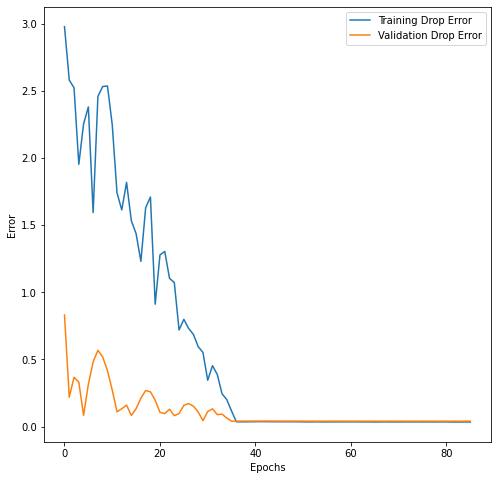

In [17]:
plot_train_val_losses(history)

In [18]:
# Evaluate MLP-based DNN and save results

y_train_pred = drop_predictor.predict(X_train)
y_test_pred = drop_predictor.predict(X_test)
y_test_unseen_pred = drop_predictor.predict(X_test_unseen)
y_test_natural_pred = drop_predictor.predict(X_test_natural)

list_y_pred_mlp = [y_train_pred, y_test_pred, y_test_unseen_pred, y_test_natural_pred]
compute_and_print_errors(list_names, list_y, list_y_pred_mlp)

Mean Absolute Error:
                 train: 0.0361
                  test: 0.0233
unseen synthetic shift: 0.0480
         natural shift: 0.0542


### LSTM

In [19]:
# Define LSTM-based DNN Performance Drop Predictor

encoded_ds_size=10

input_shape = (n_samples_per_dataset, n_features)
input_numeric = Input(shape=input_shape, name='dataset')

encoded_data = Bidirectional(LSTM(units=encoded_ds_size, return_sequences=False,
                             input_shape=input_shape), name='encoded_dataset')(input_numeric)

encoded_data = Dropout(0.2, name='perf_drop_dropout')(encoded_data)
performance_drop = Dense(1, kernel_initializer='normal', name='perf_drop')(encoded_data)

drop_predictor = KerasModel(inputs=input_numeric, outputs=performance_drop)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
# Train LSTM-based DNN Performance Drop Predictor
    
np.random.seed(random_state)
set_random_seed(random_state)

if os.path.exists('./mdc_net.h5'):
    os.remove('./mdc_net.h5')
        
drop_predictor.compile(loss='mean_absolute_error',
              optimizer=Adam(lr),
              metrics=['mean_absolute_error'])

callbacks = [ModelCheckpoint(filepath='./mdc_net.h5', monitor='val_loss', 
                             verbose=verbose, save_best_only=True, mode='min'),
             EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=early_stop_patience)]

history = drop_predictor.fit(
    X_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=verbose
)

drop_predictor = load_model('./mdc_net.h5')

/Users/smaggio/workspace/dnn_performance_drop_prediction_under_drift/env_dnn_performance_drop_prediction/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [21]:
drop_predictor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dataset (InputLayer)         [(None, 475, 9)]          0         
_________________________________________________________________
encoded_dataset (Bidirection (None, 20)                1600      
_________________________________________________________________
perf_drop_dropout (Dropout)  (None, 20)                0         
_________________________________________________________________
perf_drop (Dense)            (None, 1)                 21        
Total params: 1,621
Trainable params: 1,621
Non-trainable params: 0
_________________________________________________________________


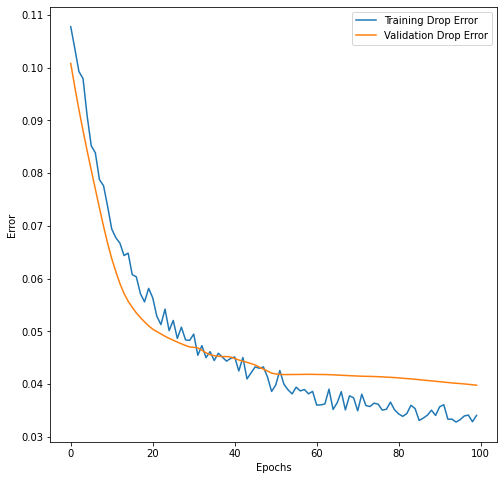

In [22]:
plot_train_val_losses(history)

In [23]:
# Evaluate LSTM-based DNN and save results

y_train_pred = drop_predictor.predict(X_train)
y_test_pred = drop_predictor.predict(X_test)
y_test_unseen_pred = drop_predictor.predict(X_test_unseen)
y_test_natural_pred = drop_predictor.predict(X_test_natural)

list_y_pred_lstm = [y_train_pred, y_test_pred, y_test_unseen_pred, y_test_natural_pred]
compute_and_print_errors(list_names, list_y, list_y_pred_lstm)

Mean Absolute Error:
                 train: 0.0325
                  test: 0.0254
unseen synthetic shift: 0.0521
         natural shift: 0.0592


## Compare all models

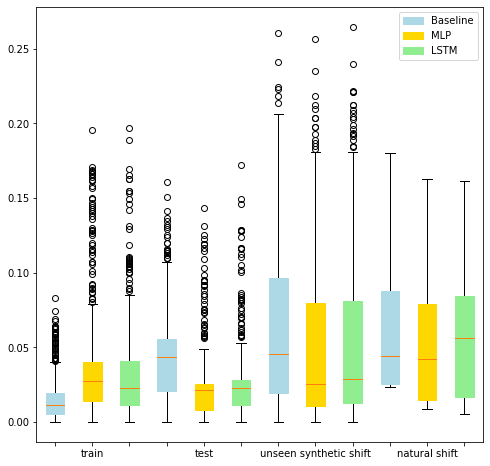

In [24]:
all_pred = [list_y_pred, list_y_pred_mlp, list_y_pred_lstm]
model_names = ['Baseline', 'MLP', 'LSTM']

plot_mae_all_models(list_names, list_y, all_pred, model_names)

## Possible Improvements

Also tried out (with similar results as above):
* Custom layer to shuffle dataset rows at each training iteration
* Tuning LR scheduling and model hidden sizes